# 3.1 线性回归

## 3.1.2 矢量化加速

In [28]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [29]:
n=10000
a=np.ones(n)
b=np.ones(n)

In [30]:
# 定义计时器
class Timer:  #@save
    def __init__(self):
        self.times=[]
        self.start()
    
    def start(self):
        "启动计时器"
        self.tik=time.time()
        
    def stop(self):
        "停止计时器"
        self.times.append(time.time()-self.tik)
        return self.times[-1]
    
    def avg(self):
        "返回平均时间"
        return sum(self.times)/len(self.times)
    
    def cumsum(self):
        "返回累计时间"
        return np.array(self.times).cumsum().tolist()

In [31]:
# 每次执行一位的加法
c=np.zeros(n)
timer=Timer()
for i in range(n):
    c[i]=a[i]+b[i]
f'{timer.stop():.5f} sec'

'0.00399 sec'

In [32]:
# 计算按元素的和
timer.start()
d=a+b
f'{timer.stop():.5f} sec'

'0.00000 sec'

## 3.1.3 正态分布与平方损失

In [33]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma ** 2)
    return p * np.exp(-0.5 / sigma ** 2 * (x - mu)**2)

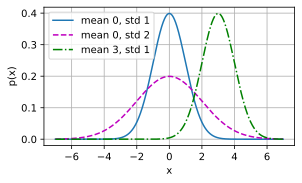

In [34]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])
plt.show()
plt.close()

# 3.2 线性回归

## 3.2.1 生成数据集

In [35]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [36]:
# matmul
import torch
x = torch.tensor([1,2])
y = torch.tensor([[5,6,7],[8,9,10]])
print(torch.matmul(x,y),torch.matmul(x,y).size())

tensor([21, 24, 27]) torch.Size([3])


In [37]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print(features)
print(labels)

tensor([[-0.5098, -1.5361],
        [-0.3117,  1.0428],
        [-1.1631, -0.0693],
        ...,
        [-1.3775,  1.9608],
        [ 0.3689,  0.0955],
        [-0.5025,  1.1171]])
tensor([[ 8.4104e+00],
        [ 4.1422e-02],
        [ 2.0928e+00],
        [ 4.9959e+00],
        [ 7.1915e+00],
        [ 3.9910e+00],
        [ 1.8826e+00],
        [ 4.4566e+00],
        [ 9.9566e+00],
        [ 1.5229e-01],
        [ 6.8707e+00],
        [ 2.7123e-01],
        [ 1.1898e+01],
        [ 4.5727e+00],
        [-3.1924e+00],
        [ 2.0251e+00],
        [ 8.8272e-01],
        [ 7.1692e+00],
        [ 4.6886e+00],
        [-4.3081e+00],
        [ 1.0881e+01],
        [ 1.9824e+00],
        [ 7.8041e+00],
        [ 9.2328e-01],
        [ 1.1812e+01],
        [ 4.9541e+00],
        [ 4.4976e+00],
        [-1.4868e+00],
        [ 1.6051e+00],
        [ 6.5044e+00],
        [ 3.8089e+00],
        [ 2.3274e+00],
        [ 5.4591e+00],
        [ 2.0839e+00],
        [-1.7867e+00],
        [ 7.1

In [38]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.5098, -1.5361]) 
label: tensor([8.4104])


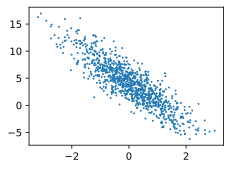

In [39]:
d2l.set_figsize()
plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1);
plt.show()
plt.close()

## 3.2.2 读取数据集 

In [40]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [41]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3559, -0.6618],
        [ 0.9581, -0.7212],
        [-0.9624,  0.3211],
        [-0.6969, -1.0939],
        [-0.1726, -0.8097],
        [-0.5298,  0.7061],
        [-1.7596,  1.7080],
        [-0.2940,  0.1284],
        [ 0.6698, -0.3417],
        [-2.2643, -0.8795]]) 
 tensor([[ 7.1479],
        [ 8.5668],
        [ 1.1759],
        [ 6.5112],
        [ 6.6047],
        [ 0.7417],
        [-5.1174],
        [ 3.1814],
        [ 6.7077],
        [ 2.6657]])


## 3.2.3 初始化模型参数

In [42]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print(w)
print(b)

tensor([[-0.0021],
        [-0.0032]], requires_grad=True)
tensor([0.], requires_grad=True)


## 3.2.4 定义模型

In [43]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 3.2.5 定义损失函数

In [44]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 3.2.6 定义优化算法

In [45]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 3.2.7 训练

In [46]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041215
epoch 2, loss 0.000159
epoch 3, loss 0.000050


In [47]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0003,  0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0012], grad_fn=<RsubBackward1>)


# 3.5 图像分类数据集

In [48]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
import matplotlib.pyplot as plt

d2l.use_svg_display()

## 3.5.1 读取数据集

In [262]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

100%|█████████████████████████| 26421880/26421880 [00:09<00:00, 2819523.37it/s]


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100%|████████████████████████████████| 29515/29515 [00:00<00:00, 182029.88it/s]


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100%|███████████████████████████| 4422102/4422102 [00:02<00:00, 1538411.53it/s]


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [49]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [50]:
mnist_train[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [51]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [52]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [53]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize=(num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.show()
    plt.close()
    return axes

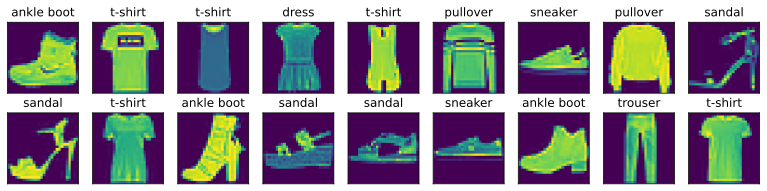

In [54]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

## 3.5.2 读取小批量

In [55]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [56]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'6.67 sec'

## 3.5.3 整合所有组件

In [57]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [58]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# 3.6 softmax回归的从零开始实现

In [59]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)# In [49]

## 3.6.1 初始化模型参数

In [60]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)
W.shape, b.shape

(torch.Size([784, 10]), torch.Size([10]))

## 3.6.2 定义softmax操作

In [61]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [62]:
def softmax(x):
    X_exp = torch.exp(x)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

In [63]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0576, 0.2914, 0.0845, 0.1171, 0.4494],
         [0.7224, 0.0795, 0.0926, 0.0083, 0.0971]]),
 tensor([1.0000, 1.0000]))

## 3.6.3 定义模型

In [64]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

## 3.6.4 定义损失函数

In [65]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[range(len(y_hat)), y]

tensor([0.1000, 0.5000])

In [66]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat,y)

tensor([2.3026, 0.6931])

## 3.6.5 分类精度

In [67]:
def accuracy(y_hat, y): #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值索引
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [68]:
accuracy(y_hat, y) / len(y)

0.5

In [69]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [70]:
# 创建两个变量，存储预测正确的数量和预测的总数量
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [71]:
evaluate_accuracy(net, test_iter)

0.0957

## 3.6.6 训练 

In [77]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())  # 用于计算数组中满足指定条件的元素个数
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [78]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [79]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evalate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [75]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

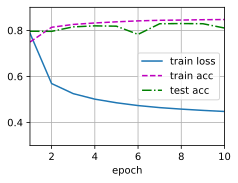

In [76]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 3.6.7 预测

In [239]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

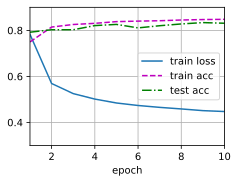

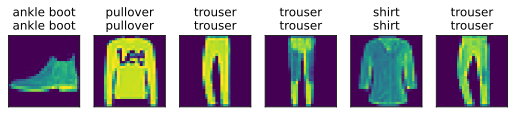

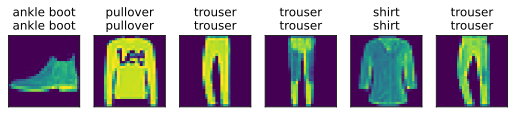

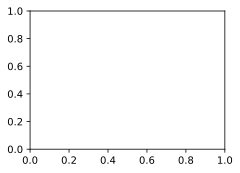

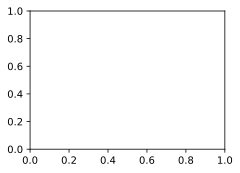

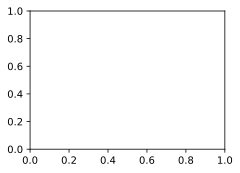

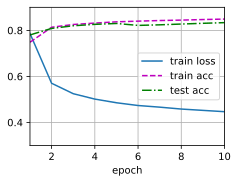

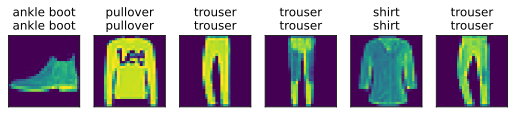

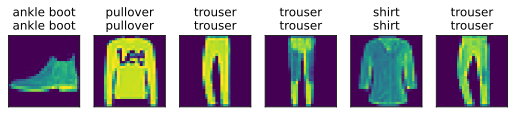

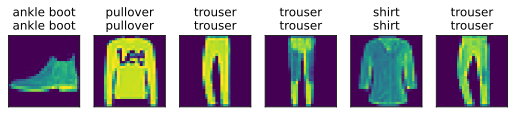

In [240]:
predict_ch3(net, test_iter)

# 3.7 softmax回归的简介实现

In [227]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 3.7.1 初始化模型参数

In [228]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

## 3.7.2 重新审视softmax的实现

In [229]:
loss = nn.CrossEntropyLoss(reduction='none')

## 3.7.3 优化算法

In [230]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 3.7.4 训练

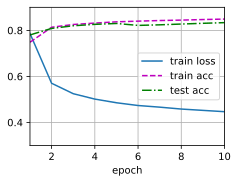

In [236]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)